In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!python --version

Python 3.7.16


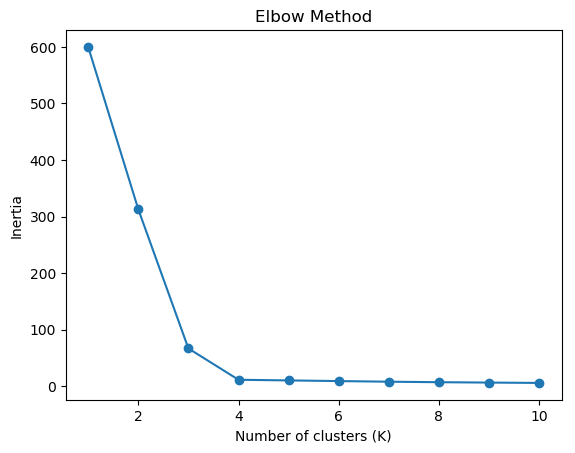

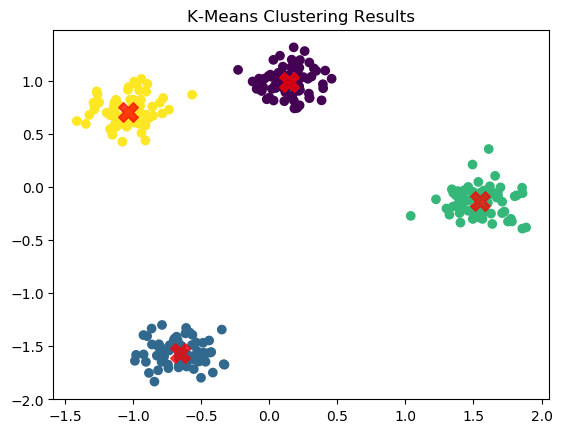

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 데이터 생성 및 스케일링
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 최적의 K 찾기 (엘보우 방법)
inertia_list = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia_list, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.show() # 그래프에서 K=4가 최적임을 확인

# 3. K-Means 모델 학습 및 예측
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 4. 결과 시각화
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering Results')
plt.show()

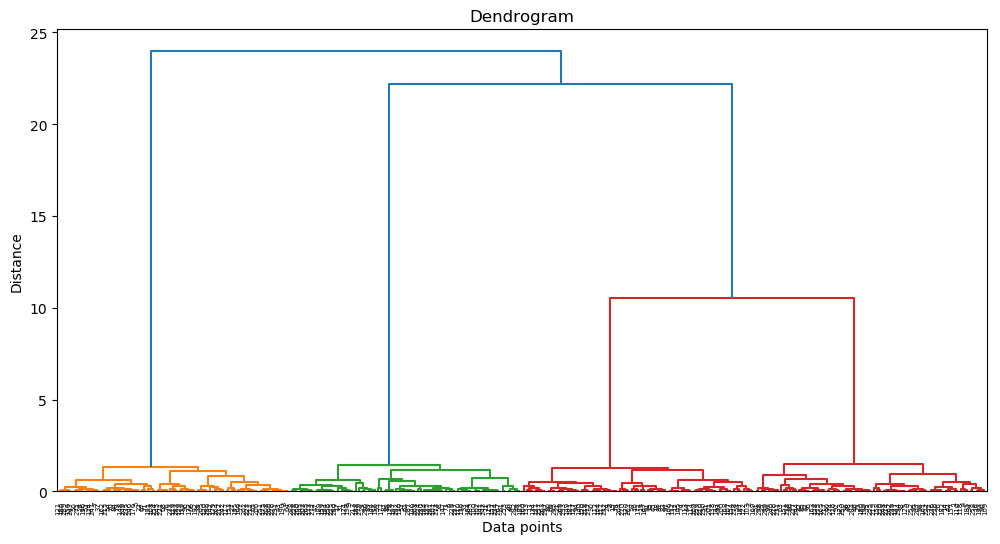

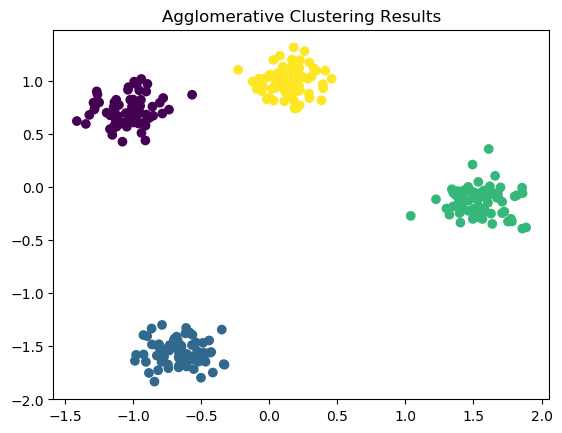

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# 1. 덴드로그램 시각화
# linkage_matrix = linkage(데이터, method='연결방법')
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

# 2. AgglomerativeClustering 모델 학습
# 덴드로그램을 보고 적절한 군집 수(n_clusters)를 결정
agg_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_scaled)

# 3. 결과 시각화
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', marker='o')
plt.title('Agglomerative Clustering Results')
plt.show()

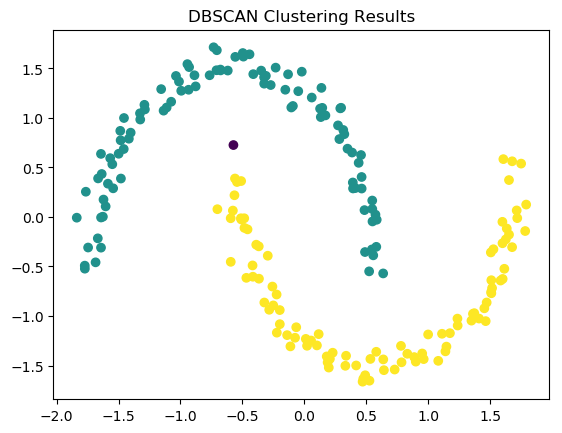

군집 레이블 종류: [-1  0  1]


In [5]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

# 1. 데이터 생성 (복잡한 형태)
X_moon, y_moon = make_moons(n_samples=200, noise=0.05, random_state=42)
X_moon_scaled = StandardScaler().fit_transform(X_moon)

# 2. DBSCAN 모델 학습
# eps: 이웃을 찾기 위한 거리
# min_samples: 군집을 형성하기 위한 최소 샘플 수
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_moon_scaled) # -1은 노이즈(이상치)를 의미

# 3. 결과 시각화
plt.scatter(X_moon_scaled[:, 0], X_moon_scaled[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering Results')
plt.show()

print("군집 레이블 종류:", np.unique(dbscan_labels)) # [-1  0  1]

In [6]:
from sklearn.metrics import silhouette_score, silhouette_samples

# K-Means 결과로 실루엣 계수 계산
score = silhouette_score(X_scaled, cluster_labels)
print(f"K-Means Silhouette Score: {score:.3f}") # 0.839

K-Means Silhouette Score: 0.839


In [8]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 준비 (리스트의 리스트 형태)
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

# 2. 데이터를 트랜잭션 형태로 변환
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
print("--- Transaction Data ---")
print(df)

--- Transaction Data ---
   Apple   Corn   Dill   Eggs  Ice cream  Kidney Beans   Milk  Nutmeg  Onion  \
0  False  False  False   True      False          True   True    True   True   
1  False  False   True   True      False          True  False    True   True   
2   True  False  False   True      False          True   True   False  False   
3  False   True  False  False      False          True   True   False  False   
4  False   True  False   True       True          True  False   False   True   

   Unicorn  Yogurt  
0    False    True  
1    False    True  
2    False   False  
3     True    True  
4    False   False  


In [9]:
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
print("\n--- Frequent Itemsets (min_support >= 0.6) ---")
print(frequent_itemsets)


--- Frequent Itemsets (min_support >= 0.6) ---
    support                     itemsets
0       0.8                       (Eggs)
1       1.0               (Kidney Beans)
2       0.6                       (Milk)
3       0.6                      (Onion)
4       0.6                     (Yogurt)
5       0.8         (Kidney Beans, Eggs)
6       0.6                (Onion, Eggs)
7       0.6         (Milk, Kidney Beans)
8       0.6        (Onion, Kidney Beans)
9       0.6       (Kidney Beans, Yogurt)
10      0.6  (Onion, Kidney Beans, Eggs)


In [10]:
# 연관 규칙 생성
# metric: 규칙을 필터링할 기준 ('confidence', 'lift' 등).
# min_threshold: metric의 최소 임계값.
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print("\n--- Association Rules (min_confidence >= 0.7) ---")
# antecedents: 선행 항목, consequents: 후행 항목
# antecedent support, consequent support: 각 항목 집합의 지지도
# support, confidence, lift: 규칙의 지지도, 신뢰도, 향상도
# leverage, conviction: 다른 연관성 척도
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


--- Association Rules (min_confidence >= 0.7) ---
              antecedents            consequents  support  confidence  lift
0          (Kidney Beans)                 (Eggs)      0.8        0.80  1.00
1                  (Eggs)         (Kidney Beans)      0.8        1.00  1.00
2                 (Onion)                 (Eggs)      0.6        1.00  1.25
3                  (Eggs)                (Onion)      0.6        0.75  1.25
4                  (Milk)         (Kidney Beans)      0.6        1.00  1.00
5                 (Onion)         (Kidney Beans)      0.6        1.00  1.00
6                (Yogurt)         (Kidney Beans)      0.6        1.00  1.00
7   (Onion, Kidney Beans)                 (Eggs)      0.6        1.00  1.25
8           (Onion, Eggs)         (Kidney Beans)      0.6        1.00  1.00
9    (Kidney Beans, Eggs)                (Onion)      0.6        0.75  1.25
10                (Onion)   (Kidney Beans, Eggs)      0.6        1.00  1.25
11                 (Eggs)  (Onion, Ki

In [11]:
# FP-Growth 알고리즘으로 빈번항목집합 찾기
frequent_itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
print("\n--- Frequent Itemsets (min_support >= 0.6) ---")
print(frequent_itemsets)

NameError: name 'fpgrowth' is not defined